## Imports and Definitions ##

In [8]:
from datasets import Dataset, DatasetDict
from transformers import set_seed, AutoTokenizer, DataCollatorWithPadding, TrainingArguments, AutoModelForSequenceClassification, AutoConfig, Trainer, TextClassificationPipeline, pipeline, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.utils import resample
from collections import Counter
from sklearn.model_selection import train_test_split
import json
import os

def number_classes(data):
    unique_labels = set()
    
    for dataset_name in data:
        dataset = data[dataset_name]

        df = pd.DataFrame(dataset)
        df = df.dropna(subset=['labels'])
        
        unique_labels.update(df['labels'].unique())
    
    return len(unique_labels)

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def tokenize_function(batch):
    tokenized_batch = tokenizer(batch['text'], truncation=True)
    return tokenized_batch

def classify_texts_in_batches(texts, batch_size=64):
    n = len(texts)
    predictions_and_scores = []
    for start_idx in range(0, n, batch_size):
        end_idx = min(start_idx + batch_size, n)
        batch = texts[start_idx:end_idx]
        batch_results = classifier(batch, truncation=True)
        batch_predictions_and_scores = [(result['label'], result['score']) for result in batch_results]
        predictions_and_scores.extend(batch_predictions_and_scores)
        print(f"Processed {end_idx}/{n} texts")
    return predictions_and_scores

## Load the Dataset and Convert it to a HuggingFace Dataset ##

In [9]:
checkpoint = 'bert-base-multilingual-uncased'
classifier_type = 'product'
model_path = f'~/Desktop/thesis/bert-models/{checkpoint}/results_{classifier_type}'
dataset_path = '~/Desktop/Tickets/data_processed.csv'
seed = 3
epochs = 5

df = pd.read_csv(dataset_path)
df = df.dropna(subset=[classifier_type])
df = df.rename(columns={classifier_type: 'labels'})

# Filter out classes with counts less than 3
label_counts = df['labels'].value_counts()
classes_to_keep = label_counts[label_counts > 2].index.tolist()
df = df[df['labels'].isin(classes_to_keep)]

# Convert textual labels to unique integers
unique_labels = df['labels'].unique()
label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
id_to_label = {idx: label for label, idx in label_to_id.items()}
df['labels'] = df['labels'].map(label_to_id)

train_df, remaining_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=seed)
test_df, validation_df = train_test_split(remaining_df, test_size=0.5, stratify=remaining_df['labels'], random_state=seed)

# Convert to a HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
validation_dataset = Dataset.from_pandas(validation_df)

data = DatasetDict({
    'train': train_dataset,
    'test': test_dataset,
    'validation': validation_dataset
})

## Resample Dataset ##

In [10]:
df_train = data['train'].to_pandas()

X = df_train.drop('labels', axis=1)
y = df_train['labels']

desired_samples = 100
resampled_data = []

for class_label in y.unique():
    class_data = df_train[df_train['labels'] == class_label]
    
    if class_data.shape[0] > desired_samples: 
        # Downsample if more than desired_samples
        resampled_class_data = resample(class_data, replace=False, n_samples=desired_samples, random_state=seed)
    elif class_data.shape[0] < desired_samples: 
        # Oversample if fewer than desired_samples
        resampled_class_data = resample(class_data, replace=True, n_samples=desired_samples, random_state=seed)
    else: 
        # If exactly desired_samples, use as is
        resampled_class_data = class_data
        
    resampled_data.append(resampled_class_data)

df_resampled = pd.concat(resampled_data)
df_resampled = df_resampled.sample(frac=1, random_state=seed).reset_index(drop=True)
data_resampled = Dataset.from_pandas(df_resampled)
data['train'] = data_resampled

## Print the Number of Instances per Class ##

{'Sonstiges': 100, 'IDES': 100, 'SAP Business Warehouse & Business Objects': 100, 'GBS/Digital Transformation Curriculum': 100, 'GBI': 100, 'TS410': 100, 'SAP4School': 100, 'Celonis': 100, 'HANA': 100, 'UCC Portal': 100, 'Business by Design': 100, 'Entwicklungssystem/Mandant': 100, 'Lumira': 100, 'ERPsim': 100}


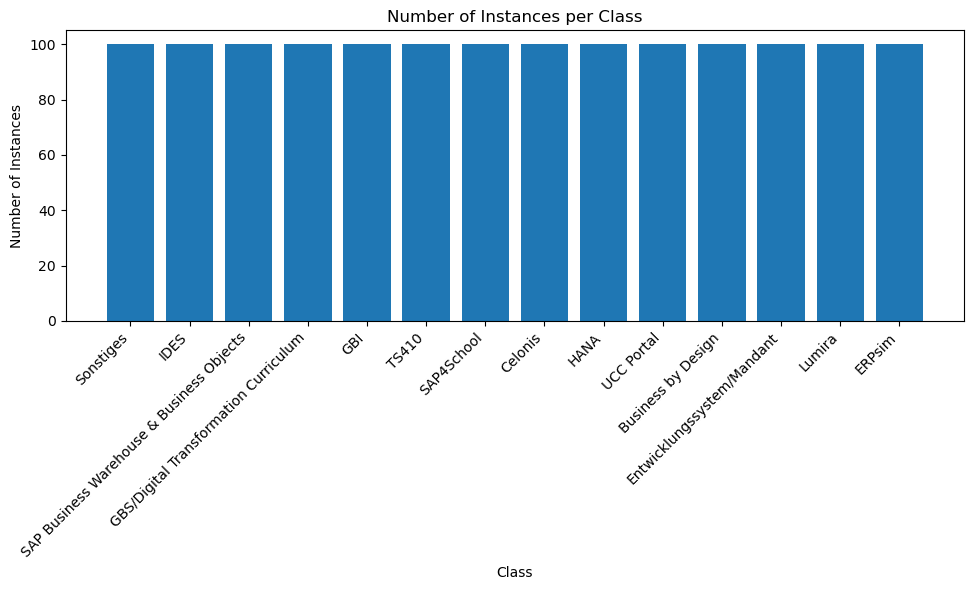

In [11]:
label_counts = Counter(data['train']['labels'])
label_counts_readable = {id_to_label[label]: count for label, count in label_counts.items()}

print(label_counts_readable)

plt.figure(figsize=(10, 6))
plt.bar(label_counts_readable.keys(), label_counts_readable.values())
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Number of Instances per Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Fine-tune the Model ##

In [12]:
set_seed(seed)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenized_datasets = data.map(tokenize_function, batched=False)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map: 100%|██████████| 491/491 [00:00<00:00, 4377.38 examples/s]


In [13]:
config = AutoConfig.from_pretrained(checkpoint, label2id=label_to_id, id2label=id_to_label, num_labels=number_classes(data))
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)

training_args = TrainingArguments(
    output_dir = 'trainer-output',
    num_train_epochs=epochs,
    evaluation_strategy='epoch',
    logging_strategy='epoch',
    load_best_model_at_end=True,
    save_strategy='epoch',
    metric_for_best_model='eval_loss',
    greater_is_better=False
)

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3  # Number of steps with no improvement after which training will be stopped
)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

/home/lsw/miniconda3/envs/ucc/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/lsw/miniconda3/envs/ucc/lib/python3.12/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
trainer.train()

KeyboardInterrupt: 

In [ ]:
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer)

# Save the model, tokenizer, pipeline and log history
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
pipeline.save_pretrained(model_path)
log_history = trainer.state.log_history
log_history_path = os.path.join(model_path, "log_history.json")
with open(log_history_path, 'w') as f:
    json.dump(log_history, f)

## Load Pipeline ##

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
classifier = pipeline(task='sentiment-analysis', model=model_path, device=0 if device == 'cuda' else -1)

## Plot Training / Validation Loss ##

In [ ]:
log_history_path = os.path.join(model_path, "log_history.json")

with open(log_history_path, 'r') as f:
    log_history = json.load(f)

training_losses = []
validation_losses = []
epochs = []

for entry in log_history:
    if 'loss' in entry:
        training_losses.append(entry['loss'])
        if 'epoch' in entry:
            epochs.append(entry['epoch'])
    elif 'eval_loss' in entry:
        validation_losses.append(entry['eval_loss'])

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, 'bo-', label='Training Loss')
plt.plot(epochs, validation_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Log History ##

In [ ]:
file_path = f'{model_path}/log_history.json'

with open(file_path, 'r') as f:
    data = json.load(f)

epoch_data = {}

for item in data:
    epoch = item.get('epoch')
    if 'loss' in item:
        epoch_data.setdefault(epoch, {})['Training Loss'] = item.get('loss')
    elif epoch in epoch_data and item.get('eval_loss') != None:
        epoch_data[epoch].update({
            'Validation Loss': item.get('eval_loss'),
            'Accuracy': item.get('eval_accuracy'),
            'F1': item.get('eval_f1'),
            'Precision': item.get('eval_precision'),
            'Recall': item.get('eval_recall')
        })

data_rows = [{'Epoch': epoch, **metrics} for epoch, metrics in epoch_data.items()]
df = pd.DataFrame(data_rows)
print(df.to_string(index=False))

## Create Confusion Matrix ##

In [ ]:
true_labels = data['test']['labels']
texts = data['test']['text']

predictions = classifier(texts, truncation=True)

predicted_labels = [label_to_id[pred['label']] for pred in predictions]
max_id = max(label_to_id.values())

class_labels = [id_to_label[id] if id in id_to_label else f"Label_{id}" for id in range(max_id + 1)]
cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(class_labels)))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(cm_normalized, cmap=plt.cm.Blues)
cbar = fig.colorbar(cax, ax=ax, shrink=0.80)

ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels, rotation=90)
ax.set_yticklabels(class_labels)

plt.xlabel('Predicted Class')
plt.ylabel('True Class')

ax.xaxis.set_tick_params(labeltop=False, labelbottom=True)
ax.tick_params(top=False, right=False)

for (i, j), val in np.ndenumerate(cm):
    text_color = 'white' if cm_normalized[i, j] > 0.65 else 'black'
    ax.text(j, i, f'{cm_normalized[i, j]:.2f}\n{val}', ha='center', va='center', color=text_color)

plt.show()

In [ ]:
'''id_to_label = {0: 'Sonstiges',
 1: 'SAP Business Warehouse',
 2: 'GBI',
 3: 'IDES',
 4: 'Entwicklungssystem',
 5: 'HANA',
 6: 'ERPsim',
 7: 'TS410',
 8: 'Business by Design',
 9: 'UCC Portal',
 10: 'Lumira',
 11: 'SAP4School',
 12: 'GBS',
 13: 'Celonis'}

id_to_label = {
 0: 'SAP Business Warehouse',
 1: 'Global Bike',
 2: 'Entwicklungssystem',
 3: 'HANA',
 4: 'ERPsim',
 5: 'TS410',
 6: 'Business by Design',
 7: 'UCC Portal',
 8: 'SAP4School'}'''

## Print Classification Report ###

In [ ]:
class_labels = [str(label) for label in class_labels]

print(classification_report(true_labels, predicted_labels, target_names=class_labels))

## Add Predictions to Dataframe and Save as CSV to Train Ensemble Classifier ##

In [ ]:
df = pd.read_csv(dataset_path)

results = classify_texts_in_batches(df['text'].tolist())
predictions, scores = zip(*results)

df['prediction'] = predictions
df['score'] = scores

output_path = f'/scratch/data_processed_{classifier_type}_with_predictions.csv'
df.to_csv(output_path, index=False)